In [1]:
import os
import base64
import openai
import json
import time
import pandas as pd
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import openai
from transformers import pipeline
# from openai import OpenAI, AzureOpenAI
from dotenv import load_dotenv
import qa_package.dataclasses.orm as d
from sqlalchemy.engine import Engine, create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy.sql import select
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from qa_package.services.openai import OpenAI
from qa_package.services.guardrails import guard_image_search
from sklearn.cluster import KMeans

load_dotenv()

API_BASE = os.getenv('API_BASE')
API_KEY = os.getenv('API_KEY')
API_VERSION = os.getenv('API_VERSION')
CHAT_DEPLOYMENT_NAME = os.getenv('CHAT_DEPLOYMENT_NAME')
EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')
NEW_API_KEY = os.getenv('MY_API_KEY')
n_clusters = 10
root_img_path = "/Users/spare/Documents/data/images/"

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def visualise_embeddings(
    embeddings: list[list[float]], top_n_pca_features=100, 
):
    pca_scores = PCA().fit_transform(embeddings)
    df_pc = pd.DataFrame(pca_scores)
    tsne_em = TSNE(n_components=2, 
        perplexity=30, early_exaggeration=12,
        n_iter=1000,learning_rate=368, 
        verbose=1).fit_transform(
            df_pc.loc[:,:top_n_pca_features]
        )
    df_pc['tsne-pca50-one'] = tsne_em[:,0]
    df_pc['tsne-pca50-two'] = tsne_em[:,1]
    matrix = np.vstack(embeddings)
    kmeans = KMeans(n_clusters = n_clusters, 
        init='k-means++', random_state=42)
    kmeans.fit(matrix)
    df_pc['y'] = kmeans.labels_
    sns.scatterplot(
        x='tsne-pca50-one', y='tsne-pca50-two',
        hue="y",
        palette=sns.color_palette("hls", 10),
        data=df_pc,
        legend="full",
        alpha=0.3,
    #     ax=ax1
    )

In [2]:
# openai.api_key = NEW_API_KEY
# openai.api_type = "open_ai"
openai.api_key = API_KEY
openai.api_type = "azure"
openai.api_base = API_BASE
openai.api_version = API_VERSION

In [3]:
CSV_FILE = "/Users/spare/Documents/data/articles.csv"
df = pd.read_csv(CSV_FILE)

- https://help.openai.com/en/articles/7102672-how-can-i-access-gpt-4 (I cannot use this)
- https://cookbook.openai.com/examples/gpt_with_vision_for_video_understanding (cannot use)
- https://huggingface.co/tasks/image-to-text
- 

#### downloading could not show progress bar
- Run this in terminal `watch du -h  ~/.cache/huggingface/hub `

In [4]:
captioner = pipeline("image-to-text",
        model="Salesforce/blip-image-captioning-base")

<img src="https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png">

- url input for caption

In [5]:
img_url = "https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png"
captioner(img_url)

/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'two birds are standing next to each other birds'}]

In [6]:
img_paths = os.listdir(root_img_path)

0554598009.jpg


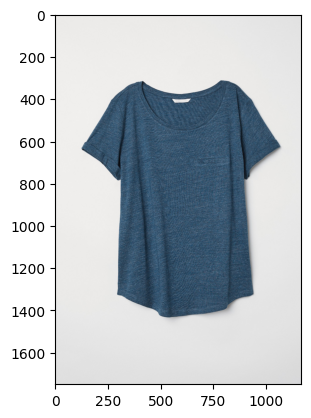

In [7]:
tmpimg = mpimg.imread(root_img_path+img_paths[0])
plt.imshow(tmpimg)
print(img_paths[0])

- local image path for caption

In [8]:
captioner(root_img_path+img_paths[0])

/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'the organic linen top in indigo blue'}]

In [9]:
df[df.article_id==int(img_paths[0].replace(".jpg",""))]

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,garment_group_name,detail_desc
157,554598009,Nora T-shirt,T-shirt,Garment Upper body,Melange,Dark Blue,Jersey Basic,"T-shirt in soft jersey with a round neck, shor..."


- base 64 encoded string for caption

In [10]:
base64_image = encode_image(root_img_path+img_paths[0])

In [11]:
captioner(base64_image)

/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'the organic linen top in indigo blue'}]

## Test embeddings with other fields

In [12]:
df

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,garment_group_name,detail_desc
0,695255001,Siv t-shirt,T-shirt,Garment Upper body,All over pattern,Dark Blue,Jersey Fancy,Short-sleeved top in soft viscose jersey with ...
1,821115007,RICHIE SKIRT,Skirt,Garment Lower body,Check,Pink,Skirts,"Short, pleated skirt in woven fabric with a hi..."
2,553238008,THORN LS TEE,Sweater,Garment Upper body,Solid,White,Jersey Basic,"Wide, long-sleeved top in soft cotton jersey w..."
3,627147001,Bling Me Up Push,Bikini top,Swimwear,Lace,Dark Red,Swimwear,"Fully lined bikini top with hole-patterned, un..."
4,794520001,Plus seam at back 1p tights,Underwear Tights,Socks & Tights,Solid,Black,Socks and Tights,Tights with a seam down the back of the legs. ...
...,...,...,...,...,...,...,...,...
995,734225001,Madonna set,Dungarees,Garment Full body,Application/3D,Light Grey,Woven/Jersey/Knitted mix Baby,Set with a pair of dungaree shorts in woven fa...
996,549332001,Mataro ED jacket,Jacket,Garment Upper body,All over pattern,Greenish Khaki,Outdoor,"Jacket in soft, patterned cotton twill with a ..."
997,720217002,Venus Braces Skirt,Skirt,Garment Lower body,Chambray,Light Blue,Dresses/Skirts girls,Gently flared dungaree dress in airy cotton ch...
998,751254003,Runaway lace dress,Dress,Garment Full body,Lace,Red,Jersey Fancy,"Short, sleeveless lace dress in a narrow cut a..."


In [13]:
client = OpenAI(
    api_key=API_KEY, api_base=API_BASE, api_version=API_VERSION
)

In [14]:
BATCH_SIZE = 16
BATCH = df.shape[0] // BATCH_SIZE + int(df.shape[0] % BATCH_SIZE > 0)
color_embeddings = []
for i in tqdm(range(BATCH)):
    docs = df["colour_group_name"]\
        [i * BATCH_SIZE : (i + 1) * BATCH_SIZE].tolist()
    vecs = client.create_embeddings(docs, EMBEDDING_DEPLOYMENT_NAME)
    color_embeddings += vecs
    if i%30 == 0:
        time.sleep(10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]


In [15]:
garment_embeddings = []
for i in tqdm(range(BATCH)):
    docs = df["garment_group_name"]\
        [i * BATCH_SIZE : (i + 1) * BATCH_SIZE].tolist()
    vecs = client.create_embeddings(docs, EMBEDDING_DEPLOYMENT_NAME)
    garment_embeddings += vecs
    if i%30 == 0:
        time.sleep(10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.72it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.426s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.956696
[t-SNE] KL divergence after 1000 iterations: -4.538664


/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


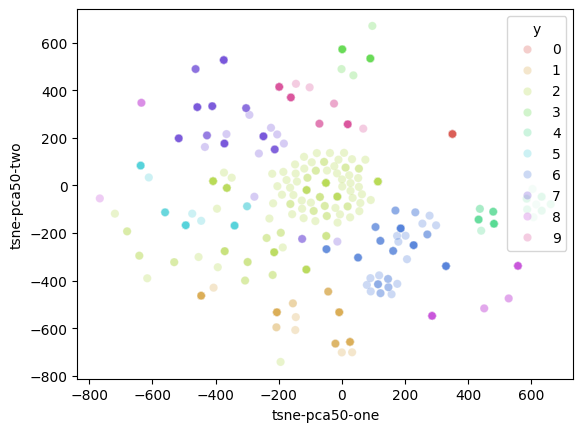

In [16]:
visualise_embeddings(color_embeddings, top_n_pca_features=200)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 10.981496
[t-SNE] KL divergence after 1000 iterations: -8.720640


/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


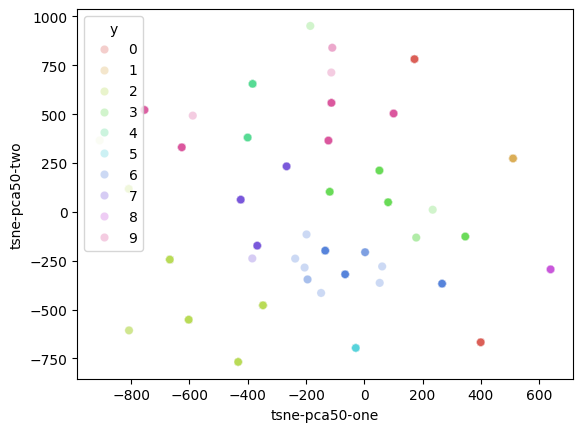

In [17]:
visualise_embeddings(garment_embeddings, top_n_pca_features=200)

In [18]:
np.unique(df.garment_group_name.to_list())

array(['Accessories', 'Blouses', 'Dressed', 'Dresses Ladies',
       'Dresses/Skirts girls', 'Jersey Basic', 'Jersey Fancy', 'Knitwear',
       'Outdoor', 'Shirts', 'Shoes', 'Shorts', 'Skirts',
       'Socks and Tights', 'Special Offers', 'Swimwear', 'Trousers',
       'Trousers Denim', 'Under-, Nightwear', 'Unknown',
       'Woven/Jersey/Knitted mix Baby'], dtype='<U29')

In [19]:
len(np.unique(df.garment_group_name.to_list()))

21

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   article_id                 1000 non-null   int64 
 1   prod_name                  1000 non-null   object
 2   product_type_name          1000 non-null   object
 3   product_group_name         1000 non-null   object
 4   graphical_appearance_name  1000 non-null   object
 5   colour_group_name          1000 non-null   object
 6   garment_group_name         1000 non-null   object
 7   detail_desc                997 non-null    object
dtypes: int64(1), object(7)
memory usage: 62.6+ KB


In [21]:
df.count()

article_id                   1000
prod_name                    1000
product_type_name            1000
product_group_name           1000
graphical_appearance_name    1000
colour_group_name            1000
garment_group_name           1000
detail_desc                   997
dtype: int64

In [22]:
for col in df:
    uni_val = df[col].unique()
    N = len(uni_val)
    print(col, N)
    if N < 100:
        print(uni_val)
    print("-------------")

article_id 1000
-------------
prod_name 987
-------------
product_type_name 70
['T-shirt' 'Skirt' 'Sweater' 'Bikini top' 'Underwear Tights' 'Shirt'
 'Sneakers' 'Trousers' 'Shorts' 'Garment Set' 'Dress' 'Underwear bottom'
 'Socks' 'Blazer' 'Swimwear bottom' 'Top' 'Hoodie' 'Other accessories'
 'Pyjama set' 'Coat' 'Bracelet' 'Jacket' 'Sandals' 'Hair clip'
 'Hair/alice band' 'Vest top' 'Hat/beanie' 'Blouse' 'Earring' 'Cardigan'
 'Scarf' 'Bra' 'Underwear body' 'Swimwear set' 'Swimsuit' 'Boots' 'Robe'
 'Pyjama jumpsuit/playsuit' 'Pyjama bottom' 'Jumpsuit/Playsuit'
 'Polo shirt' 'Nipple covers' 'Cap/peaked' 'Bodysuit' 'Sarong' 'Flat shoe'
 'Gloves' 'Outdoor trousers' 'Night gown' 'Wallet' 'Watch' 'Necklace'
 'Ballerinas' 'Other shoe' 'Leggings/Tights' 'Hair string' 'Flat shoes'
 'Flip flop' 'Bag' 'Outdoor overall' 'Beanie' 'Slippers' 'Fine cosmetics'
 'Sunglasses' 'Marker pen' 'Belt' 'Hat/brim' 'Tailored Waistcoat' 'Tie'
 'Dungarees']
-------------
product_group_name 11
['Garment Upper body' 

In [23]:
def find_images_based_on_(col_name, col_value, index=0):
    tmp = df[df[col_name]==col_value]
    print(tmp.iloc[index])
    print(len(tmp))
    fname = f"0{tmp.article_id.iloc[index]}.jpg"
    tmpimg = mpimg.imread(root_img_path+fname)
    plt.imshow(tmpimg)
    print(captioner(root_img_path+fname))
    print(fname)

article_id                                                           781078009
prod_name                                                      Kimmi blazer(1)
product_type_name                                                       Blazer
product_group_name                                          Garment Upper body
graphical_appearance_name                                      Other structure
colour_group_name                                                    Off White
garment_group_name                                                     Dressed
detail_desc                  Fitted, double-breasted jacket in woven fabric...
Name: 144, dtype: object
12


/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'the white and black checkered blazer jacket'}]
0781078009.jpg


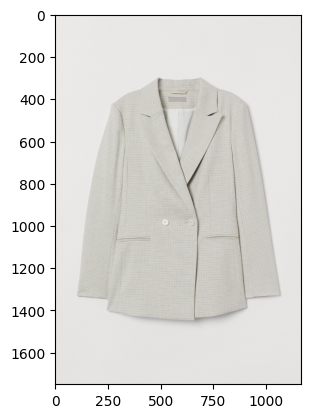

In [24]:
find_images_based_on_('garment_group_name', 'Dressed', index=1)

article_id                                                           599521001
prod_name                                                        Studio 55 Top
product_type_name                                                          Top
product_group_name                                          Garment Upper body
graphical_appearance_name                                       Application/3D
colour_group_name                                                        Black
garment_group_name                                              Dresses Ladies
detail_desc                  Backless jersey top with small round studs and...
Name: 56, dtype: object
47
[{'generated_text': 'a black and white bikini top with a black tie around the neck'}]
0599521001.jpg


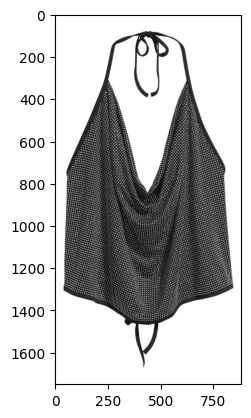

In [25]:
find_images_based_on_('garment_group_name', 'Dresses Ladies', index=2)

article_id                                                           889575001
prod_name                                                     Johan rollerneck
product_type_name                                                      Sweater
product_group_name                                          Garment Upper body
graphical_appearance_name                                              Melange
colour_group_name                                                        Black
garment_group_name                                                    Knitwear
detail_desc                  Polo-neck jumper in a cotton knit with long sl...
Name: 48, dtype: object
82
[{'generated_text': 'the turtle neck sweater in black'}]
0889575001.jpg


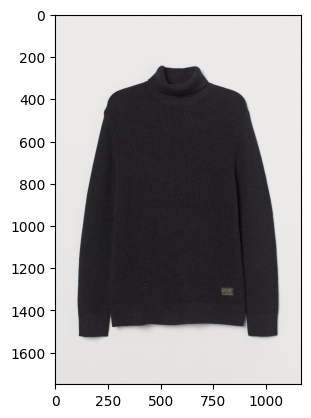

In [26]:
find_images_based_on_('garment_group_name', 'Knitwear', index=4)

In [27]:
alluni_type = []
alluni_type2 = []
for prod_group in df.product_group_name.unique():
    uni = df[df.product_group_name==prod_group].product_type_name.unique()
    uni2 = df[df.product_group_name==prod_group].garment_group_name.unique()
    print(prod_group)
    print(uni)
    print(uni2)
    alluni_type += list(uni)
    alluni_type2 += list(uni2)
    
print(len(alluni_type))
print(len(alluni_type2))

Garment Upper body
['T-shirt' 'Sweater' 'Shirt' 'Blazer' 'Top' 'Hoodie' 'Coat' 'Jacket'
 'Vest top' 'Blouse' 'Cardigan' 'Polo shirt' 'Bodysuit'
 'Tailored Waistcoat']
['Jersey Fancy' 'Jersey Basic' 'Blouses' 'Dressed' 'Knitwear' 'Outdoor'
 'Unknown' 'Dresses Ladies' 'Special Offers' 'Shirts' 'Accessories'
 'Dresses/Skirts girls' 'Under-, Nightwear'
 'Woven/Jersey/Knitted mix Baby']
Garment Lower body
['Skirt' 'Trousers' 'Shorts' 'Outdoor trousers' 'Leggings/Tights']
['Skirts' 'Trousers' 'Shorts' 'Jersey Basic' 'Trousers Denim'
 'Jersey Fancy' 'Unknown' 'Woven/Jersey/Knitted mix Baby' 'Outdoor'
 'Dresses Ladies' 'Dresses/Skirts girls' 'Knitwear' 'Socks and Tights'
 'Shirts' 'Blouses']
Swimwear
['Bikini top' 'Swimwear bottom' 'Swimwear set' 'Swimsuit' 'Sarong']
['Swimwear' 'Accessories' 'Jersey Fancy']
Socks & Tights
['Underwear Tights' 'Socks']
['Socks and Tights' 'Under-, Nightwear']
Shoes
['Sneakers' 'Sandals' 'Boots' 'Flat shoe' 'Ballerinas' 'Other shoe'
 'Flat shoes' 'Flip flop' 'Sl

article_id                                                           876125001
prod_name                                                       Twist jumpsuit
product_type_name                                            Jumpsuit/Playsuit
product_group_name                                           Garment Full body
graphical_appearance_name                                                Solid
colour_group_name                                                        Black
garment_group_name                                              Dresses Ladies
detail_desc                  Ankle-length jumpsuit in jersey with a V-neck ...
Name: 457, dtype: object
6
[{'generated_text': "the black jumpsuit is a simple, yet - fitting jumpsuit that's perfect for any"}]
0876125001.jpg


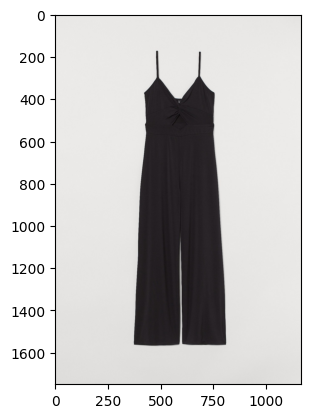

In [28]:
find_images_based_on_('product_type_name', 'Jumpsuit/Playsuit', index=4)

article_id                                                           574801003
prod_name                                                   Ben fleece overall
product_type_name                                              Outdoor overall
product_group_name                                           Garment Full body
graphical_appearance_name                                     All over pattern
colour_group_name                                                        Green
garment_group_name                                                     Outdoor
detail_desc                  All-in-one suit in soft, thermal fleece with a...
Name: 435, dtype: object
1
[{'generated_text': "baby boy's green airplane print zip rom"}]
0574801003.jpg


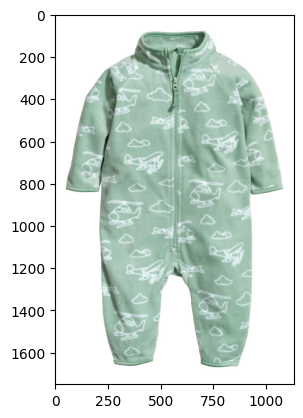

In [29]:
find_images_based_on_('product_type_name', 'Outdoor overall', index=0)

article_id                                                           683622004
prod_name                                                       PICKLE jumsuit
product_type_name                                     Pyjama jumpsuit/playsuit
product_group_name                                                   Nightwear
graphical_appearance_name                                     All over pattern
colour_group_name                                                   Other Pink
garment_group_name                                                Jersey Fancy
detail_desc                  Sleeveless playsuit in airy viscose with a pri...
Name: 780, dtype: object
4
[{'generated_text': 'the pink rom rom rom rom rom rom rom rom rom rom rom rom rom rom rom rom rom'}]
0683622004.jpg


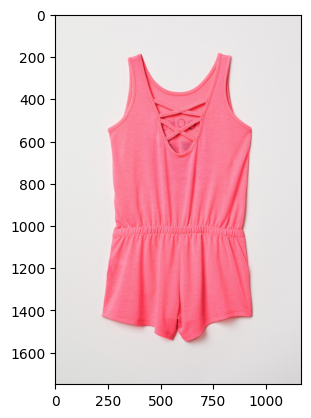

In [30]:
find_images_based_on_('product_type_name', 'Pyjama jumpsuit/playsuit', index=3)

article_id                                                           805279002
prod_name                                                            Totte set
product_type_name                                                        Skirt
product_group_name                                          Garment Lower body
graphical_appearance_name                                     All over pattern
colour_group_name                                                    Dark Blue
garment_group_name                                        Dresses/Skirts girls
detail_desc                  Set with a dungaree dress and top in soft cott...
Name: 652, dtype: object
10
[{'generated_text': 'mayoral - dress - dark blue'}]
0805279002.jpg


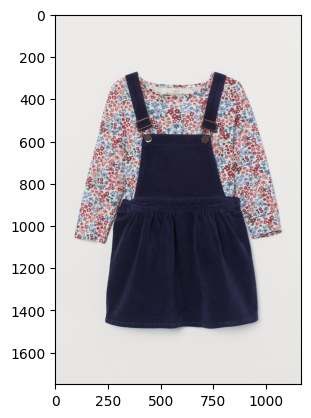

In [31]:
"""
['Jersey Fancy' 'Skirts' 'Jersey Basic' 'Swimwear' 'Socks and Tights'
 'Blouses' 'Shoes' 'Trousers' 'Shorts' 'Under-, Nightwear' 'Unknown'
 'Dressed' 'Knitwear' 'Accessories' 'Trousers Denim' 'Outdoor'
 'Dresses Ladies' 'Special Offers' 'Shirts'
 'Woven/Jersey/Knitted mix Baby' 'Dresses/Skirts girls']
"""
find_images_based_on_('garment_group_name', 'Dresses/Skirts girls', index=3)

article_id                                                           816307001
prod_name                                               PQ FILOU SKIRT LEATHER
product_type_name                                                        Skirt
product_group_name                                          Garment Lower body
graphical_appearance_name                                                Solid
colour_group_name                                                        Black
garment_group_name                                                     Unknown
detail_desc                  Calf-length skirt in leather with visible seam...
Name: 273, dtype: object
43
[{'generated_text': 'a black leather skirt with a zipper closure'}]
0816307001.jpg


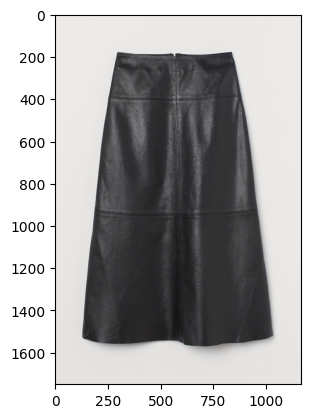

In [32]:
find_images_based_on_('garment_group_name', 'Unknown', index=10)

In [36]:
target_path = root_img_path+"0816307001.jpg"
user_question = f"""I saw this picture in {target_path} \
and I want the trousers she is wearing. What would you suggest?"""
print(user_question)
raw_llm_output, validated_output = guard_image_search(
    openai.ChatCompletion.create,
    prompt_params={'question': user_question},
    deployment_id=CHAT_DEPLOYMENT_NAME,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    max_tokens=1024,
    temperature=0.3
)
validated_output

I saw this picture in /Users/spare/Documents/data/images/0816307001.jpg and I want the trousers she is wearing. What would you suggest?


{'url': 'None',
 'path': '/Users/spare/Documents/data/images/0816307001.jpg',
 'request': 'I want the trousers she is wearing.'}

In [37]:
target_uri = "https://i.pinimg.com/564x/b3/6d/2e/b36d2ecfff8a1860ab5cc2063008414f.jpg"
user_question = f"""I saw this picture in {target_uri} \
and I want the trousers she is wearing. What would you suggest?"""
print(user_question)
raw_llm_output, validated_output = guard_image_search(
    openai.ChatCompletion.create,
    prompt_params={'question': user_question},
    deployment_id=CHAT_DEPLOYMENT_NAME,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    max_tokens=1024,
    temperature=0.3
)
validated_output

I saw this picture in https://i.pinimg.com/564x/b3/6d/2e/b36d2ecfff8a1860ab5cc2063008414f.jpg and I want the trousers she is wearing. What would you suggest?


{'url': 'https://i.pinimg.com/564x/b3/6d/2e/b36d2ecfff8a1860ab5cc2063008414f.jpg',
 'path': 'None',
 'request': 'trousers'}

In [38]:
captioner('https://i.pinimg.com/564x/b3/6d/2e/b36d2ecfff8a1860ab5cc2063008414f.jpg')

/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'a woman in a red dress and heels walking down the street'}]

In [39]:
os.listdir(root_img_path)

['0554598009.jpg',
 '0539723029.jpg',
 '0552501001.jpg',
 '0700010001.jpg',
 '0659248003.jpg',
 '0886976001.jpg',
 '0776885002.jpg',
 '0543689003.jpg',
 '0736087002.jpg',
 '0399223025.jpg',
 '0860797001.jpg',
 '0549332001.jpg',
 '0851370004.jpg',
 '0686137002.jpg',
 '0341242007.jpg',
 '0657168002.jpg',
 '0756870002.jpg',
 '0738777002.jpg',
 '0829302002.jpg',
 '0743483004.jpg',
 '0827680001.jpg',
 '0903090001.jpg',
 '0355072009.jpg',
 '0735751004.jpg',
 '0873884005.jpg',
 '0533388007.jpg',
 '0841668002.jpg',
 '0756405001.jpg',
 '0696769002.jpg',
 '0574801003.jpg',
 '0695341001.jpg',
 '0879774005.jpg',
 '0592174001.jpg',
 '0611151001.jpg',
 '0660757001.jpg',
 '0630823001.jpg',
 '0602716001.jpg',
 '0656345002.jpg',
 '0749272001.jpg',
 '0384851019.jpg',
 '0697175001.jpg',
 '0555487003.jpg',
 '0839891002.jpg',
 '0688966001.jpg',
 '0717932004.jpg',
 '0753206006.jpg',
 '0526302003.jpg',
 '0729318004.jpg',
 '0709902001.jpg',
 '0836181001.jpg',
 '0776724003.jpg',
 '0874027001.jpg',
 '0525583002